In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}')

from elastic_body import *
from utils import *
from utils_plot import plot_deformations

import os

FIGURES_PATH = os.path.join(pathlib.Path(PROJ_PATH).parent.resolve(), 'figures')

In [3]:
body, mesh, U1, T = load_res('nonlin_visc_Bsuv_0_len_500_point_dens_1_')

FileNotFoundError: [Errno 2] No such file or directory: '/media/fgarbuzov/SATA1/code-Spectral/simulation_results/nonlin_visc_Bsuv_0_len_500_point_dens_1_params'

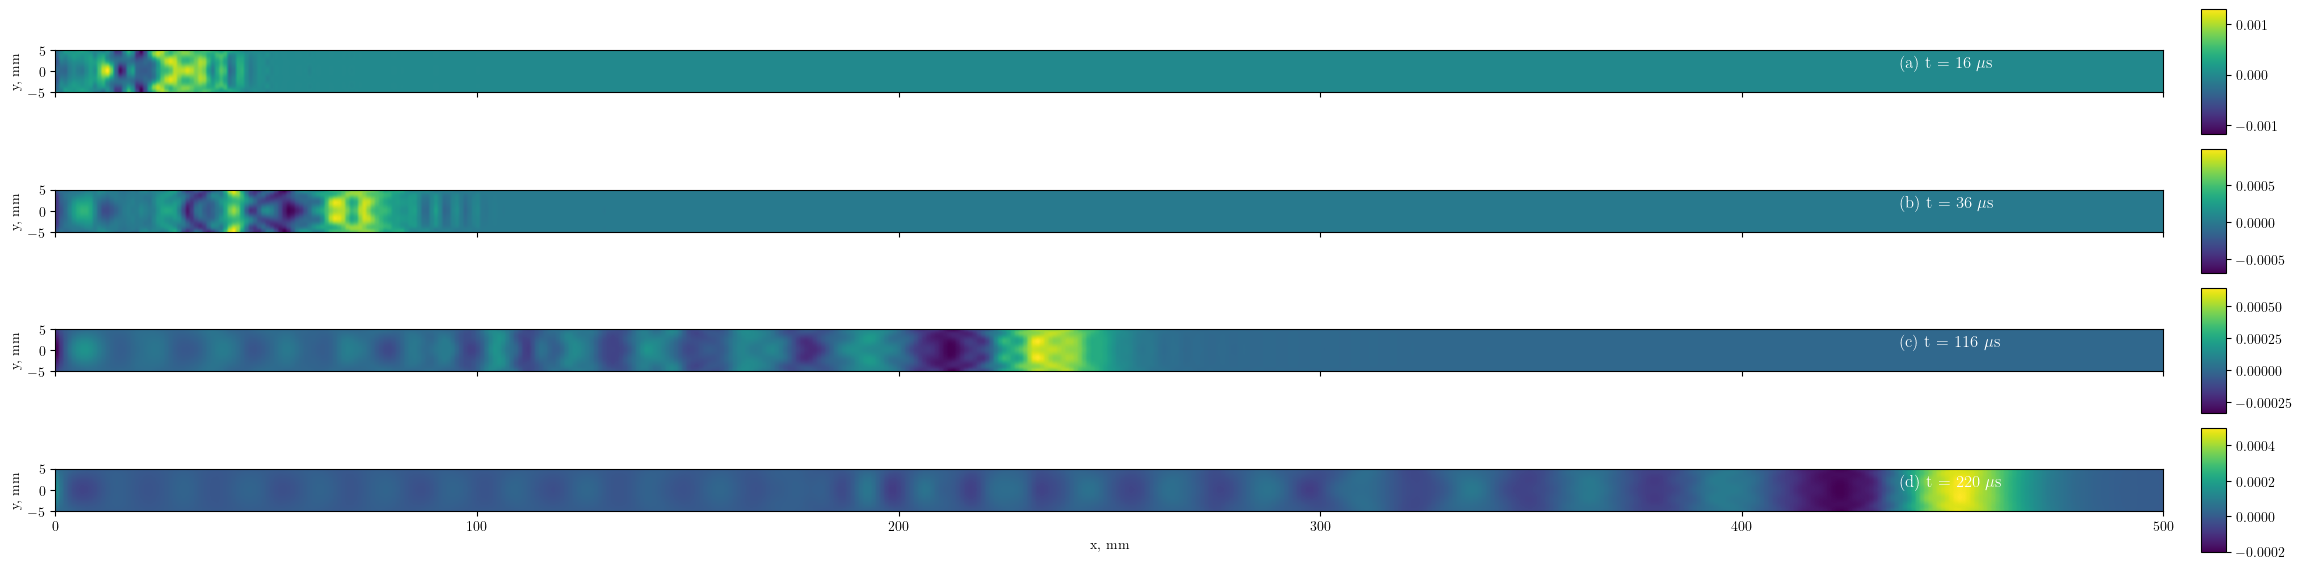

In [26]:
t = [5, 10, 30, -1]
xmax = U1.mesh.grid()[0][-1]
x = np.linspace(0, xmax, num=501)
fig, ax = plot_deformations_many_scales(-U1[:,0], T, t, diff=0, x=x)

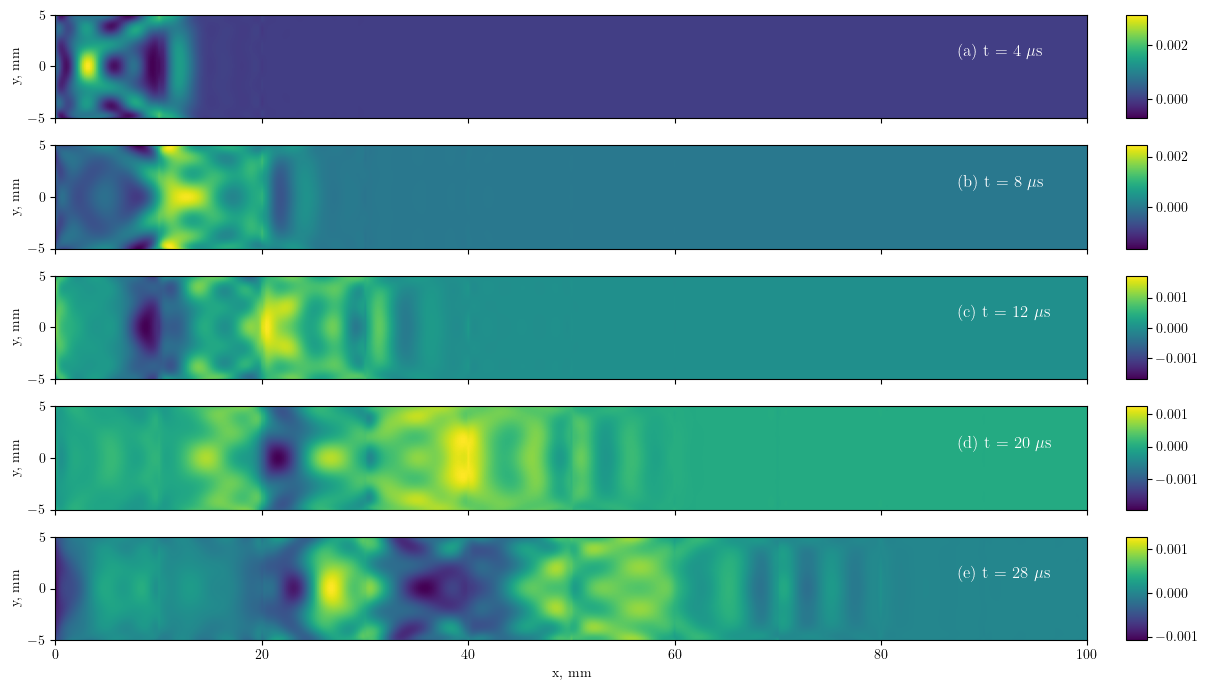

In [37]:
t = [2, 3, 4, 6, 8]
x = np.linspace(0, 100, num=501)
fig, ax = plot_deformations_many_scales(-U1[:,0], T, t, diff=0, x=x)

## Early evolution

In [6]:
# the result of this simulation is too big to be stored on github
# it can be computed using the params file with the following name:
body, mesh, U2, T = load_res('nonlin_visc_len_200_')

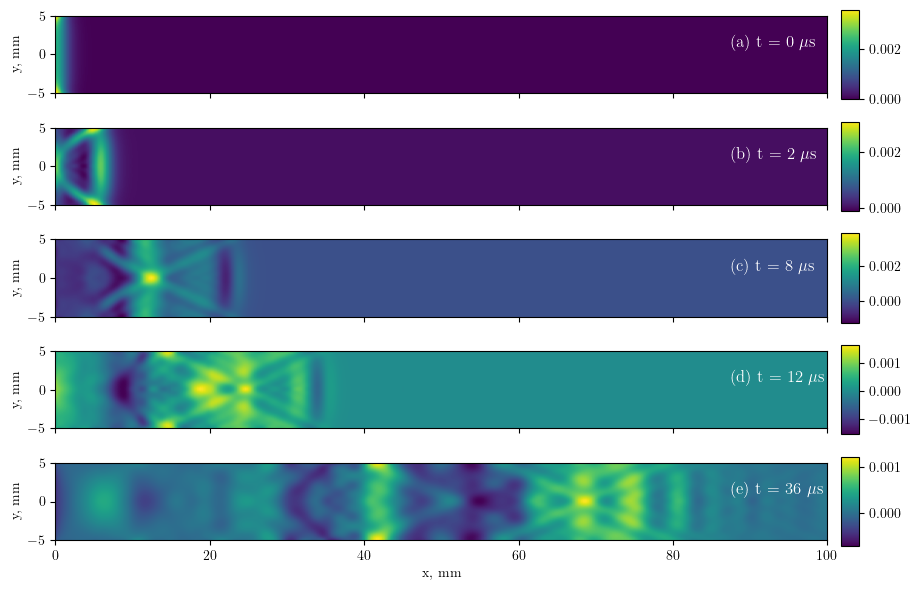

In [11]:
t = [2, 3, 6, 8, 20]
x = np.linspace(0, 100, num=501)
fig, ax = plt.subplots(len(t), 1, figsize=(10, 1 + len(t)), sharex=True)
plot_deformations(fig, ax, -U2[:,0], T, t, diff=0, x=x)

## Soliton generation

In [12]:
# the result of this simulation is too big to be stored on github
# it can be computed using the params file with the following name:
body, mesh, U_long, T = load_res('nonlin_visc_Bsuv_0_len_2000_point_dens_1_')

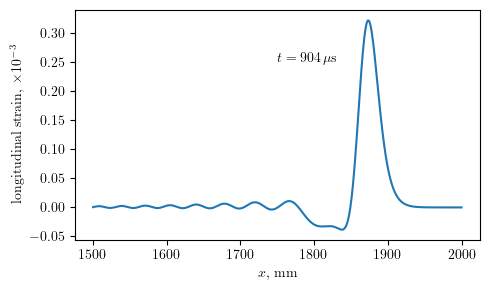

In [14]:
x = np.linspace(1500, 2000, num=501)
sc = 1000
k = -15
plt.figure(figsize=(5,3))
plt.plot(x, -sc*U_long[k,0].diff(0)(x, 0, 0))
plt.xlabel('$x$, mm')
plt.text(1750, 0.25, '$t = {:.0f}\, \mu$s'.format(T[k]))
plt.ylabel('longitudinal strain, $\\times 10^{-3}$')
plt.tight_layout()

In [15]:
def moduli_freq(omega, l0, l1, tau):
    l1 = np.asarray(l1)
    tau = np.asarray(tau)
    omega = np.asarray(omega)
    if l1.shape != () and omega.shape != ():
        omega = np.array(list(omega) * len(l1)).reshape(len(l1), len(omega))
        return l0 + np.sum(l1[:,None] * tau[:,None]**2 * omega**2 / (1 + tau[:,None]**2 * omega**2), axis=0)
    return l0 + np.sum(l1 * tau**2 * omega**2 / (1 + tau**2 * omega**2))

In [83]:
nu = body.poiss
omega = 2*np.pi*0.05 # soliton 'frequency'
# effective Lame moduli at this frequency
lam = moduli_freq(omega, body.lam, body.xi, body.tau)
mu = moduli_freq(omega, body.mu, body.eta, body.tau)
young = lame2young(lam, mu)[0]
# effective Murnaghan moduli at this frequency
l = moduli_freq(omega, body.l1[0,0], body.l1[1,0], body.nonlin_tau)
m = moduli_freq(omega, body.m1[0,0], body.m1[1,0], body.nonlin_tau)
n = moduli_freq(omega, body.n1[0,0], body.n1[1,0], body.nonlin_tau)
# effective beta (quadratic nonlinearity coeff.
beta = 3/2 + (l*(1 - 2*nu)**3 + 2*m*(1 + nu)**2*(1 - 2*nu) + 3*n*nu**2) / young
body.beta = beta
print(f"beta = {beta:.0f}; l = {l:.0f}, m = {m:.0f}, n = {n:.0f}")

def soliton_approx(u, x, x0=None):
    A = np.sign(body.beta) * np.abs(np.asarray(u)).max()
    if not x0:
        x0 = x[np.abs(u).argmax()]
    return body.soliton_kdv(A, x - x0, 0)

beta = -140; l = -2248, m = -546, n = -242


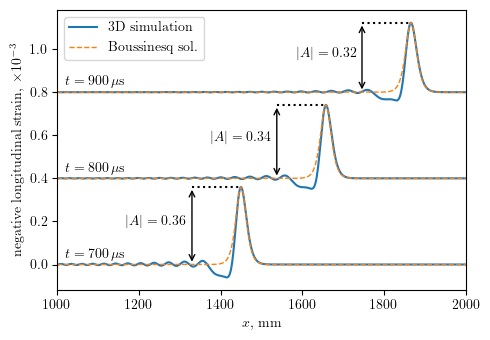

In [72]:
x = np.linspace(1000, 2000, num=1101)
sc = -1000
delta = 0.4
ann_x_delta = 120

def plot_panel(k, n, sc, delta, ann_x_delta, label1=None, label2=None):
    u = U_long[k,0].diff(0)(x, 0, 0)
    A = np.sign(beta)*np.abs(u).max()
    x0 = np.abs(u).argmax()
    ann_x = x[x0] - ann_x_delta
    plt.plot(x, n*delta + sc*u, c='C0', label=label1)
    plt.plot(x, n*delta + sc*soliton_approx(u, x)[0], '--', lw=1, c='C1', label=label2)
    plt.text(x[0] + 20, 0.03 + n*delta, '$t = {:.0f}\, \mu$s'.format(T[k]))
    plt.annotate('', xy=(ann_x, n*delta+sc*A), xytext=(ann_x,n*delta), 
                 arrowprops=dict(arrowstyle='<->'))
    plt.plot([ann_x, x[x0]], [n*delta + sc*A,]*2, ':', c='k')
    plt.text(ann_x - 160, n*delta + sc*A/2, '$|A| = {:.2f}$'.format(sc*A))

plt.figure(figsize=(5,3.5))

plot_panel(-66, 0, sc, delta, ann_x_delta)
plot_panel(-41, 1, sc, delta, ann_x_delta)
plot_panel(-16, 2, sc, delta, ann_x_delta, '3D simulation', 'Boussinesq sol.')

plt.xlim(x[0], x[-1])
plt.xlabel('$x$, mm')
plt.ylabel('negative longitudinal strain, $\\times 10^{-3}$')
plt.legend()
plt.tight_layout()